In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")

from parrot import py_predictor

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [2]:
input = pd.read_csv("../output/harmonized_screens.csv")
#input = input.drop(columns = "Unnamed: 0")
input = input[["screen", "seq", "z-score"]]
input

,screen,seq,z-score
0,controls_syn,YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE,39.863967
1,controls_syn,HLDVDLFADVEIDDPPQIDFDEVLSLVDDGQNPSSCVESF,67.641322
2,controls_syn,HLDSSNSFDAAASGDSDDDYLFDTSVLRFSNDDDGDLYLK,6.949263
3,controls_syn,HLDFPDMFDDALDLDAYDLGSLLSDIDSPMDFKDDMPTNY,49.213636
4,controls_syn,HKQSVAPTTLVDLNPIITCYSEWRSTDDLKDLLLEDFIDK,66.502383
...,...,...,...
104185,padi,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,0.730194
104186,padi,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,1.022412
104187,padi,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.331438
104188,padi,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,2.564526


In [3]:
input.to_csv('../output/harmonized_screens_parrot_input.tsv', sep='\t', index=False, header=False)

Will submit: (in parrot-lightning env)

parrot-train '../output/harmonized_screens_parrot_input.tsv' '../output/harmonized_screens_parrot_slow' -d 'sequence' -c 1 --include-figs

# Now, evaluating the model

In [4]:
import torch

checkpoint_path = "../output/harmonized_screens_parrot"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Extract the actual model state_dict from checkpoint
model_state_dict = checkpoint['state_dict']  # this key usually holds the weights
torch.save(model_state_dict, "../output/harmonized_screens_parrot_weights.pth")


In [5]:
weights_path = "../output/harmonized_screens_parrot_weights.pth"
state_dict = torch.load(weights_path, map_location='cpu')

print(list(state_dict.keys()))

['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l0_reverse', 'lstm.weight_hh_l0_reverse', 'lstm.bias_ih_l0_reverse', 'lstm.bias_hh_l0_reverse', 'layer_norm.weight', 'layer_norm.bias', 'linear_layers.0.weight', 'linear_layers.0.bias']


In [6]:
weights_path = "../output/harmonized_screens_parrot_weights.pth"
state_dict = torch.load(weights_path, map_location='cpu')

new_state_dict = {}
for k, v in state_dict.items():
    if k == 'linear_layers.0.weight':
        new_state_dict['fc.weight'] = v
    elif k == 'linear_layers.0.bias':
        new_state_dict['fc.bias'] = v
    else:
        new_state_dict[k] = v

# Remove specific keys
keys_to_remove = ["layer_norm.weight", "layer_norm.bias"]
for key in keys_to_remove:
    if key in new_state_dict:
        del new_state_dict[key]

# Save the renamed weights file
torch.save(new_state_dict, "../output/harmonized_screens_parrot_weights_fc.pth")

print("Renamed weights saved to 'harmonized_screens_parrot_weights_fc.pth'")

Renamed weights saved to 'harmonized_screens_parrot_weights_fc.pth'


In [7]:
my_predictor = py_predictor.Predictor("../output/harmonized_screens_parrot_weights_fc.pth", 
                                                dtype="sequence")
my_predictor

In [12]:
# Train/test/val
split = pd.read_csv("../output/harmonized_screens_parrot_input_split_file.txt", sep = " ", header = None)
non_null_counts = split.notnull().sum(axis=1)# / sum(split.notnull().sum(axis=1))
non_null_counts

0    62514
1    26047
2    15629
dtype: int64

In [13]:
# Get val sequences
val_indicies = split.iloc[2].dropna()
val_seqs = input.iloc[val_indicies]
val_seqs

,screen,seq,z-score
82094,padi,KQKNELVETPPSPVSVKGKSAKSFEQDLMEMQTMLEKMKI,-1.324358
79576,padi,YRKSYLSPSSTSHTPQTPETHTPLRRSARHVSRKIDLGND,-1.077139
46141,padi,MLEGLVARLASSGSSIYKALRCKDPTGPELLTYMHILYEA,15.308805
83710,padi,AYMNPYSQFAGPHQLQQPPPPPFQGQTTSQLSSGQASSSK,-1.037558
2400,controls_syn,LLARLDDVGLADVYWPDICFDESFWFLQDQTPSDVDEFLV,60.973301
...,...,...,...
44758,padi,SSVGEYKLMILQDGFIDALGGMVVYAPMNLNTAYSAISGQ,4.253681
18757,gcn4,IPDMADLNSNNSFDSNMGSGIGHTHAFDMSPWEAPVSAFT,16.172557
421,controls_syn,HDDGDLFGEDLFSSEDIMFFALFDPTRNRSHQSELKSIWT,63.328558
21659,gcn4,WLENPFLNQFIAGFDLIGEEATEKHPLIYHVATLYWFKKK,7.216474


In [14]:
# val_seqs.to_csv("../output/harmonized_screens_parrot_val.tsv", sep = "\t", index=False, header=False)

In [15]:
val_seqs["pred"] = val_seqs["seq"].apply(lambda seq: my_predictor.predict(seq))
val_seqs

,screen,seq,z-score,pred
82094,padi,KQKNELVETPPSPVSVKGKSAKSFEQDLMEMQTMLEKMKI,-1.324358,[0.040507495]
79576,padi,YRKSYLSPSSTSHTPQTPETHTPLRRSARHVSRKIDLGND,-1.077139,[0.0022634268]
46141,padi,MLEGLVARLASSGSSIYKALRCKDPTGPELLTYMHILYEA,15.308805,[0.20693356]
83710,padi,AYMNPYSQFAGPHQLQQPPPPPFQGQTTSQLSSGQASSSK,-1.037558,[0.059791744]
2400,controls_syn,LLARLDDVGLADVYWPDICFDESFWFLQDQTPSDVDEFLV,60.973301,[5.3153367]
...,...,...,...,...
44758,padi,SSVGEYKLMILQDGFIDALGGMVVYAPMNLNTAYSAISGQ,4.253681,[0.47419882]
18757,gcn4,IPDMADLNSNNSFDSNMGSGIGHTHAFDMSPWEAPVSAFT,16.172557,[2.9990714]
421,controls_syn,HDDGDLFGEDLFSSEDIMFFALFDPTRNRSHQSELKSIWT,63.328558,[2.6538014]
21659,gcn4,WLENPFLNQFIAGFDLIGEEATEKHPLIYHVATLYWFKKK,7.216474,[0.961172]


In [18]:
val_seqs["pred"] = val_seqs["pred"].apply(lambda _: _[0])
val_seqs

,screen,seq,z-score,pred
82094,padi,KQKNELVETPPSPVSVKGKSAKSFEQDLMEMQTMLEKMKI,-1.324358,0.040507
79576,padi,YRKSYLSPSSTSHTPQTPETHTPLRRSARHVSRKIDLGND,-1.077139,0.002263
46141,padi,MLEGLVARLASSGSSIYKALRCKDPTGPELLTYMHILYEA,15.308805,0.206934
83710,padi,AYMNPYSQFAGPHQLQQPPPPPFQGQTTSQLSSGQASSSK,-1.037558,0.059792
2400,controls_syn,LLARLDDVGLADVYWPDICFDESFWFLQDQTPSDVDEFLV,60.973301,5.315337
...,...,...,...,...
44758,padi,SSVGEYKLMILQDGFIDALGGMVVYAPMNLNTAYSAISGQ,4.253681,0.474199
18757,gcn4,IPDMADLNSNNSFDSNMGSGIGHTHAFDMSPWEAPVSAFT,16.172557,2.999071
421,controls_syn,HDDGDLFGEDLFSSEDIMFFALFDPTRNRSHQSELKSIWT,63.328558,2.653801
21659,gcn4,WLENPFLNQFIAGFDLIGEEATEKHPLIYHVATLYWFKKK,7.216474,0.961172


In [19]:
# val_seqs["pred"] = val_seqs["pred"] /10
# val_seqs

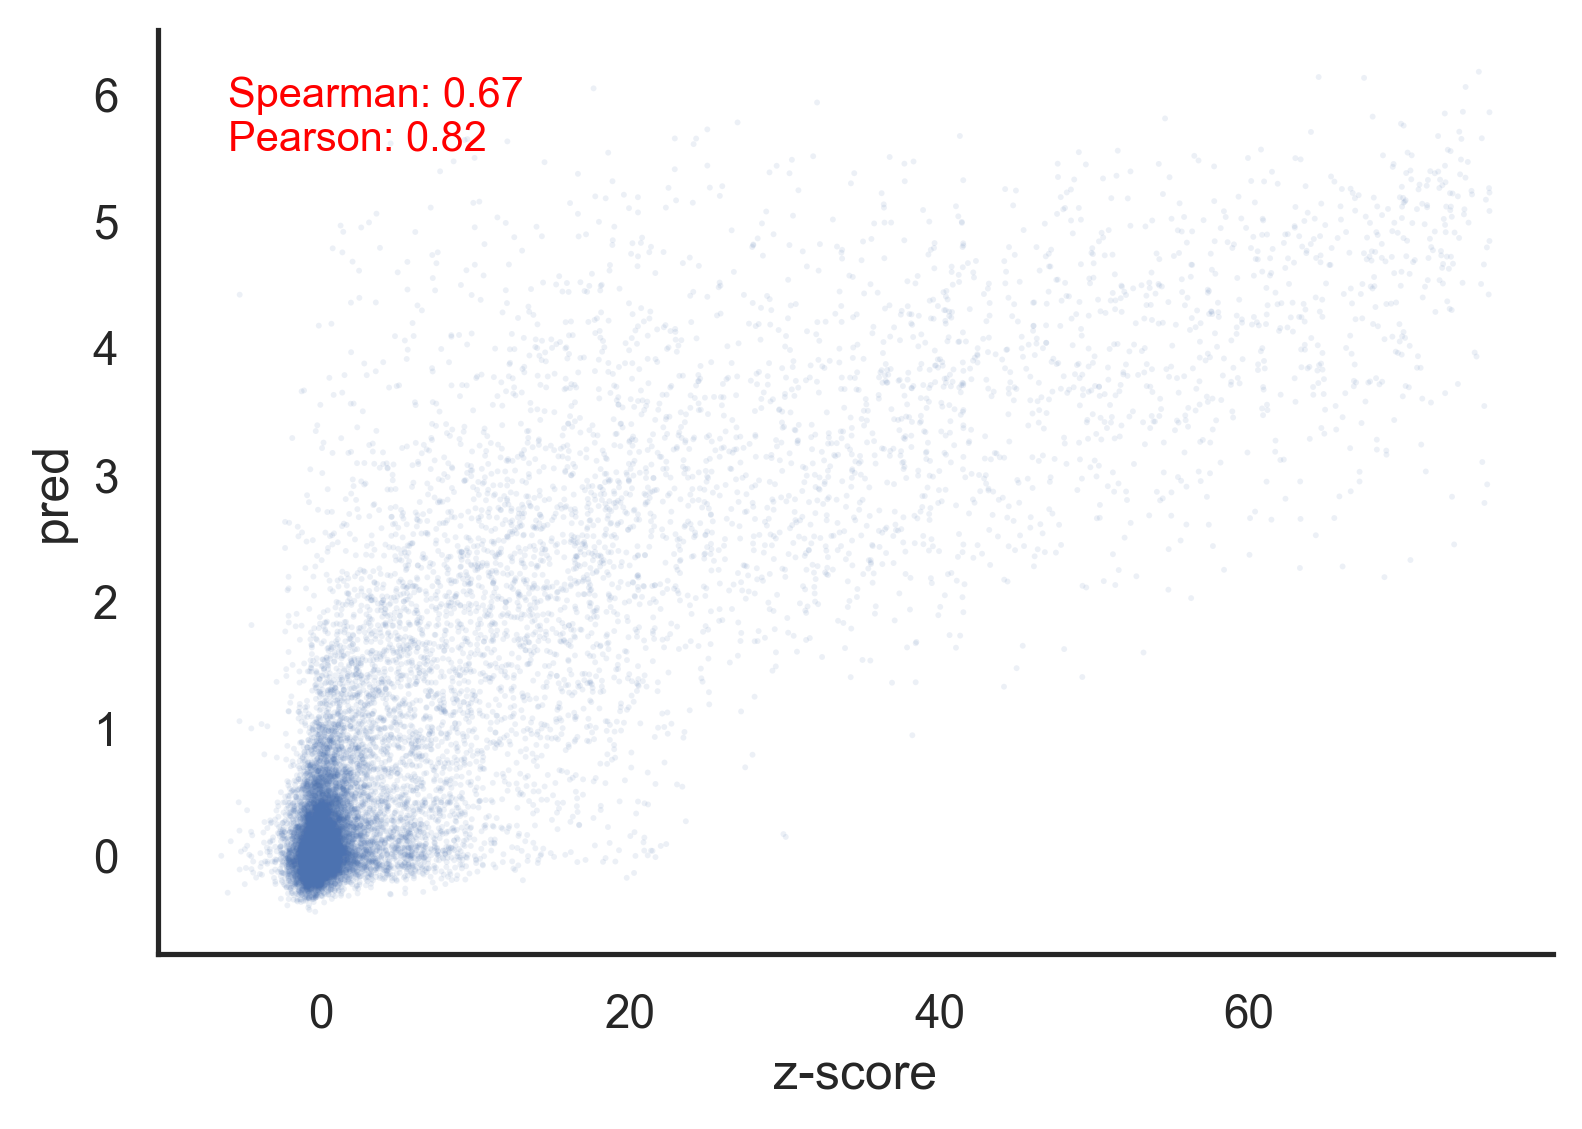

In [ ]:
from scipy.stats import spearmanr, pearsonr

sns.scatterplot(data=val_seqs, x="z-score", y="pred", alpha=0.1, edgecolor='none', s=2)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(val_seqs["z-score"], val_seqs["pred"])
# Calculate Pearson correlation
pearson_corr, _ = pearsonr(val_seqs["z-score"], val_seqs["pred"])

# Add text to the figure
plt.text(0.05, 0.95, f"Spearman: {spearman_corr:.2f}\nPearson: {pearson_corr:.2f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color = 'red')

sns.despine()

# Plot y = x line
# plt.plot([val_seqs["z-score"].min(), val_seqs["z-score"].max()], 
#          [val_seqs["z-score"].min(), val_seqs["z-score"].max()], 
#          color='blue', linestyle='--', linewidth=1)

plt.show()

In [22]:
slow_parrot_predictor = py_predictor.Predictor("../output/harmonized_screens_parrot_slow", 
                                                dtype="sequence")
slow_parrot_predictor

In [ ]:
val_seqs["slow_pred"] = val_seqs["seq"].apply(lambda seq: slow_parrot_predictor.predict(seq))
val_seqs["slow_pred"] = val_seqs["slow_pred"].apply(lambda _: _[0])
val_seqs

,screen,seq,z-score,pred,slow_pred
82094,padi,KQKNELVETPPSPVSVKGKSAKSFEQDLMEMQTMLEKMKI,-1.324358,0.040507,-0.205326
79576,padi,YRKSYLSPSSTSHTPQTPETHTPLRRSARHVSRKIDLGND,-1.077139,0.002263,-0.000819
46141,padi,MLEGLVARLASSGSSIYKALRCKDPTGPELLTYMHILYEA,15.308805,0.206934,0.547195
83710,padi,AYMNPYSQFAGPHQLQQPPPPPFQGQTTSQLSSGQASSSK,-1.037558,0.059792,-0.139530
2400,controls_syn,LLARLDDVGLADVYWPDICFDESFWFLQDQTPSDVDEFLV,60.973301,5.315337,53.818718
...,...,...,...,...,...
44758,padi,SSVGEYKLMILQDGFIDALGGMVVYAPMNLNTAYSAISGQ,4.253681,0.474199,1.157690
18757,gcn4,IPDMADLNSNNSFDSNMGSGIGHTHAFDMSPWEAPVSAFT,16.172557,2.999071,22.287092
421,controls_syn,HDDGDLFGEDLFSSEDIMFFALFDPTRNRSHQSELKSIWT,63.328558,2.653801,27.811848
21659,gcn4,WLENPFLNQFIAGFDLIGEEATEKHPLIYHVATLYWFKKK,7.216474,0.961172,3.089364


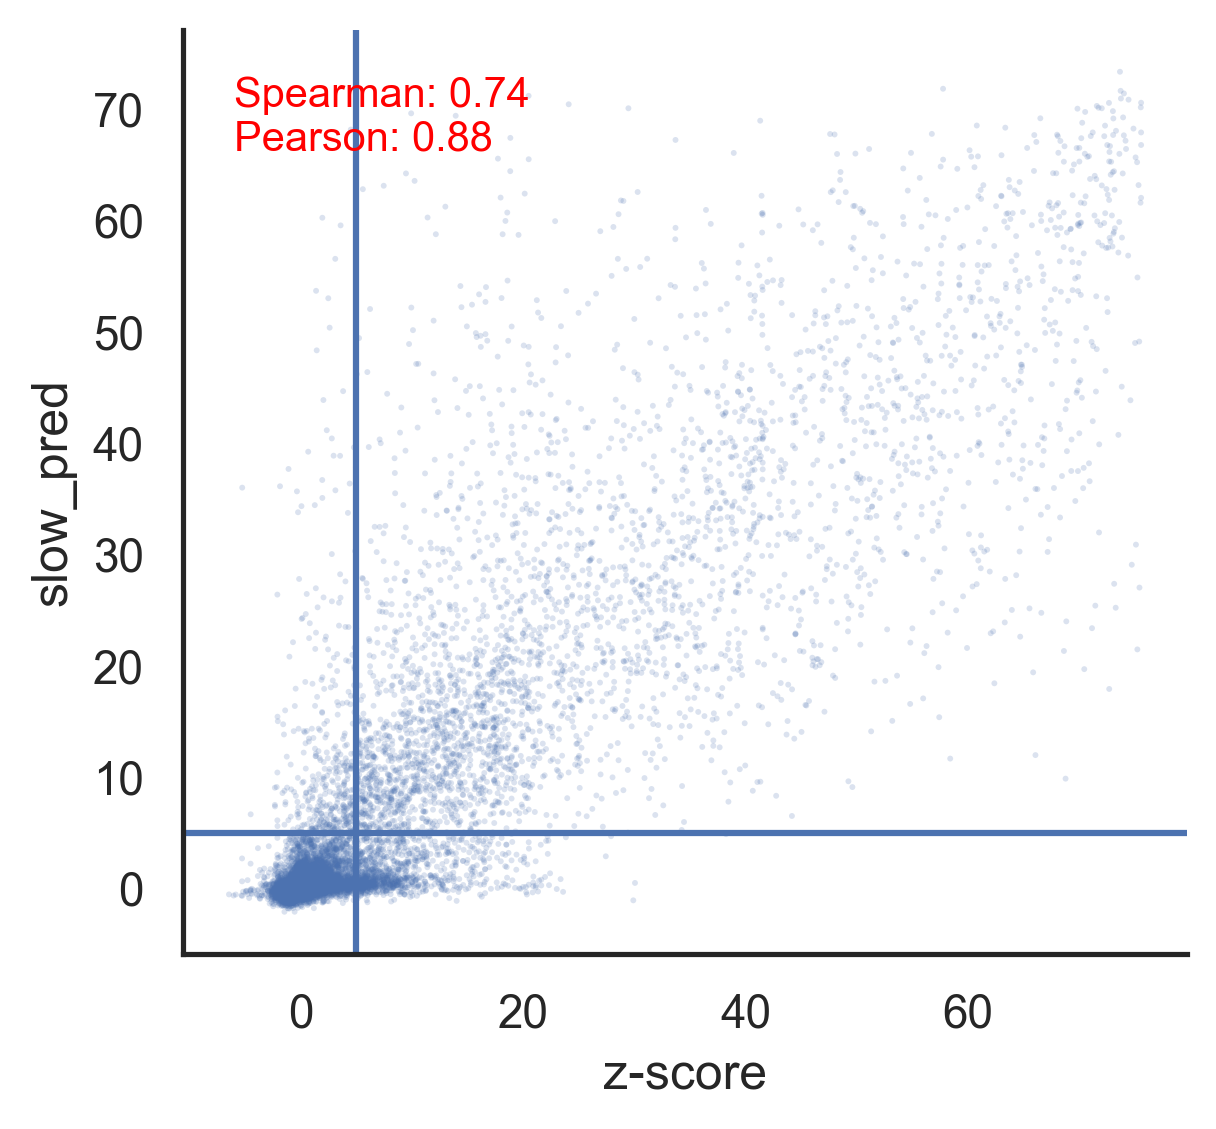

In [41]:
from scipy.stats import spearmanr, pearsonr

sns.scatterplot(data=val_seqs, x="z-score", y="slow_pred", alpha=0.2, edgecolor='none', s=2)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(val_seqs["z-score"], val_seqs["slow_pred"])
# Calculate Pearson correlation
pearson_corr, _ = pearsonr(val_seqs["z-score"], val_seqs["slow_pred"])

# Add text to the figure
plt.text(0.05, 0.95, f"Spearman: {spearman_corr:.2f}\nPearson: {pearson_corr:.2f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color = 'red')

sns.despine()

# Plot y = x line
# plt.plot([val_seqs["z-score"].min(), val_seqs["z-score"].max()], 
#          [val_seqs["z-score"].min(), val_seqs["z-score"].max()], 
#          color='black', linestyle='-', linewidth=1, alpha = 0.5)

plt.axvline(5)
plt.axhline(5)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()
